#### Title:          06_framework_vs_vicon_preprocessing.ipynb
#### Description:    Merge Vicon and framework data into one file per framework 
#### Authors:        Fabian Kahl and Maximilian Kapsecker

### 1. General Functionality and Definitions

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from matplotlib.backends.backend_pdf import PdfPages
from PIL import Image
from itertools import product
import json
from utils import *

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.precision', 2)
path_to_csvs = '../data/area_fileformat/'
path_to_complete_csv = '../data/csvs_complete/'
path_control_plots = '../data/control_plots/'
framework = 'MoveNet'
vicon_cut_path = '../data/non_area_fileformat/frameworks/VICON/'
path_best_shifts = '../data/best_shifts/'
init_df = True

In [2]:
# Column name mapping
mapping = {
    'leftShoulder': 'LSJC',
    'leftElbow': 'LEJC',
    'leftHand': 'LWJC',
    'leftHip': 'LHJC',
    'leftKnee': 'LKJC',
    'leftFoot': 'LAJC',
    'rightShoulder': 'RSJC',
    'rightElbow': 'REJC',
    'rightHand': 'RWJC',
    'rightHip': 'RHJC',
    'rightKnee': 'RKJC',
    'rightFoot': 'RAJC'
}

# Exercise name mapping
mapping_ex = {
    'FrontLunge': 'Front lunge',
    'JumpingJacks': 'Jumping jacks',
    'LegExtensionCrunch': 'Leg extension crunch',
    'ReverseFly': 'Reverse fly',
    'SideSquat': 'Side squat',
    'SingleLegDeadlift': 'Single leg deadlift',
    'Squat': 'Squat',
    'LateralArmRaise': 'Lateral arm raise'
}

# Parameters
exercises = ['Front lunge', 'Jumping jacks', 'Lateral arm raise',
             'Leg extension crunch', 'Reverse fly', 'Side squat',
             'Single leg deadlift', 'Squat']

views = ['Frontal', 'Side']

# parent - angle - child
angles = [['leftHip', 'leftShoulder', 'leftElbow'],
          ['leftShoulder', 'leftElbow', 'leftHand'],
          ['rightHip', 'rightShoulder', 'rightElbow'],
          ['rightShoulder', 'rightElbow', 'rightHand'],
          ['leftShoulder', 'leftHip', 'leftKnee'],
          ['leftHip', 'leftKnee', 'leftFoot'],
          ['rightShoulder', 'rightHip', 'rightKnee'],
          ['rightHip', 'rightKnee', 'rightFoot'],
         ]

angles_benchmark = pd.DataFrame(index=exercises, columns=views)
angles_benchmark.loc['Front lunge'] = [['rightHip', 'rightKnee', 'rightFoot'],
                                       ['rightHip', 'rightKnee', 'rightFoot']]
angles_benchmark.loc['Jumping jacks'] = [['leftHip', 'leftShoulder', 'leftElbow'],
                                         ['leftHip', 'leftShoulder', 'leftElbow']]
angles_benchmark.loc['Lateral arm raise'] = [['leftHip', 'leftShoulder', 'leftElbow'],
                                            ['leftHip', 'leftShoulder', 'leftElbow']]
angles_benchmark.loc['Leg extension crunch'] = [['rightShoulder', 'rightHip', 'rightKnee'],
                                                ['rightHip', 'rightKnee', 'rightFoot']]
angles_benchmark.loc['Reverse fly'] = [['rightShoulder', 'leftShoulder', 'leftElbow'],
                                      ['rightShoulder', 'leftShoulder', 'leftElbow']]
angles_benchmark.loc['Side squat'] = [['rightHip', 'rightKnee', 'rightFoot'],
                                     ['rightHip', 'rightKnee', 'rightFoot']]
angles_benchmark.loc['Single leg deadlift'] = [['leftShoulder', 'leftHip', 'leftKnee'],
                                              ['leftShoulder', 'leftHip', 'leftKnee']]
angles_benchmark.loc['Squat'] = [['rightHip', 'rightKnee', 'rightFoot'],
                                ['rightHip', 'rightKnee', 'rightFoot']]

In [3]:
cols_vicon = generate_vicon_column_set(mapping)
cols_framework = generate_framework_column_set(mapping)

### 2. Loading Data

This is how the underlying filestructure looks like.

In [4]:
list_files(path_to_csvs)

/
    .DS_Store
03/
    .DS_Store
    ViTPose/
        03_Video_LateralArmRaise_Side.csv
        03_Video_LateralArmRaise_Frontal.csv
        03_Video_ReverseFly_Side.csv
        03_Video_LegExtensionCrunch_Frontal.csv
        03_Video_JumpingJacks_Side.csv
        03_Video_Squat_Side.csv
        03_Video_FrontLunge_Frontal.csv
        03_Video_ReverseFly_Frontal.csv
        03_Video_JumpingJacks_Frontal.csv
        03_Video_LegExtensionCrunch_Side.csv
        03_Video_Squat_Frontal.csv
        03_Video_FrontLunge_Side.csv
        03_Video_SideSquat_Frontal.csv
        03_Video_SingleLegDeadlift_Side.csv
        03_Video_SingleLegDeadlift_Frontal.csv
        03_Video_SideSquat_Side.csv
    YOLOv7/
        03_Video_LateralArmRaise_Side.csv
        03_Video_LateralArmRaise_Frontal.csv
        03_Video_ReverseFly_Side.csv
        03_Video_LegExtensionCrunch_Frontal.csv
        03_Video_JumpingJacks_Side.csv
        03_Video_Squat_Side.csv
        03_Video_FrontLunge_Frontal.csv
        03

In [5]:
if init_df == True:
    json_file = os.path.join(vicon_cut_path, 'Vicon_cut.json')
    # Load the JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    # Init the final dataframe
    df = pd.DataFrame()
    subjects = glob.glob(path_to_csvs+"*")

    for k in subjects:
        subject = k.split('/')[-1]

        # Sub dataframes for framework and vicon data
        df_framework = pd.DataFrame()
        df_vicon = pd.DataFrame()

        files_subject_vicon = glob.glob(path_to_csvs+subject+'/Vicon/*.csv')
        # Drop unwanted csv files
        files_subject_vicon = drop_unnecessary_elements(files_subject_vicon, exercises)
        print(k.split('/')[-1], 'has', len(files_subject_vicon), 'Vicon files.')

        # Iterate over all vicon files for one individual
        for j in files_subject_vicon:
            temp_vicon = pd.read_csv(j, skiprows=2, low_memory=False)

            # Vicon csv files do not follow a strict table based format according the following editing becomes necessary
            remember = 'default'
            cols = []
            for i, m in enumerate(np.array(temp_vicon.columns)):
                temp = ''
                if 'Unnamed' in m:
                    aa = remember + '_' + str(temp_vicon[m][0]) + '_' + str(temp_vicon[m][1])
                else:
                    base = m.replace('Takashi:' , '')
                    base = base.replace(':' , '')
                    base = base.replace('Sub10' , '')
                    base = base.replace('Sub1' , '')
                    base = base.replace('Sub2' , '')
                    base = base.replace('Sub3' , '')
                    base = base.replace('Sub4' , '')
                    base = base.replace('Sub5' , '')
                    base = base.replace('Sub6' , '')
                    base = base.replace('Sub7' , '')
                    base = base.replace('Sub8' , '')
                    base = base.replace('Sub9' , '')
                    aa = base + '_' + str(temp_vicon[m][0]) + '_' + str(temp_vicon[m][1])
                    remember = base
                cols.append(aa)
            temp_vicon.columns = cols
            temp_vicon = temp_vicon[cols_vicon]
            temp_vicon = temp_vicon.rename(columns={'default_Frame_nan': 'Frame'})
            temp_vicon = temp_vicon.drop([0, 1])
            starttime, endtime = start_to_end(j[:-3] + 'xcp')
            temp_vicon.Frame = (temp_vicon.Frame.astype(float) / 250.0) * 1000.0
            temp_vicon.Frame = [starttime + datetime.timedelta(milliseconds=fra) for fra in temp_vicon.Frame]
            # Videos and Vicon have a timely delay of 2 hours (= 7200 s)
            temp_vicon['timestamp_vicon'] = ((temp_vicon.Frame - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s')) - 7200.0
            temp_vicon['timestamp_start_vicon'] = temp_vicon.iloc[0].timestamp_vicon
            temp_vicon['timestamp_stop_vicon'] = temp_vicon.iloc[-1].timestamp_vicon
            temp_vicon['timestamp'] = temp_vicon['timestamp_vicon'] - temp_vicon['timestamp_start_vicon']
            temp_vicon['file_name'] = j
            temp_vicon['subject'] = j.split('/')[-1].split(' ')[0]
            temp_vicon['exerciseName'] = j.split('/')[-1].split(' ', 1)[1].split('.')[0]
            
            # Find right cut details
            sub, exercise = os.path.splitext(os.path.basename(j))[0].replace(' ', '_').split('_', 1)
            substring = ('0'+sub[3:])[-2:]+'_'+exercise
            substring_frontal = substring+'_Frontal'
            substring_side = substring+'_Side'
            matching_entry = None
            f = False
            s = False
            for entry in data:
                if substring_frontal in entry['timestamp']:
                    matching_entry_f = entry
                    f = True
                if substring_side in entry['timestamp']:
                    matching_entry_s = entry
                    s = True
                if f and s:
                    break
            del f, s
            start_time_f = matching_entry_f['label'][0]['start']
            end_time_f = matching_entry_f['label'][0]['end']
            start_time_s = matching_entry_s['label'][0]['start']
            end_time_s = matching_entry_s['label'][0]['end']
            
            # Cut vicon data
            temp_vicon_f = temp_vicon[(temp_vicon['timestamp'] >= start_time_f) & (temp_vicon['timestamp'] <= end_time_f)].copy()
            temp_vicon_s = temp_vicon[(temp_vicon['timestamp'] >= start_time_s) & (temp_vicon['timestamp'] <= end_time_s)].copy()
            
            # Correct timestamps
            temp_vicon_f['timestamp'] = temp_vicon_f['timestamp'] - start_time_f
            temp_vicon_s['timestamp'] = temp_vicon_s['timestamp'] - start_time_s

            # Add view
            temp_vicon_f['ipad_view'] = 'Frontal'
            temp_vicon_s['ipad_view'] = 'Side'
            
            df_vicon = pd.concat([df_vicon, temp_vicon_f], ignore_index=True)
            df_vicon = pd.concat([df_vicon, temp_vicon_s], ignore_index=True)

        # Load the framework data, both side and frontal view
        files_subject_framework = glob.glob(path_to_csvs+subject+'/'+framework+'/*.csv')
        for l in files_subject_framework:
            temp = pd.read_csv(l)
            temp.rename(columns={'Timestamp': 'timestamp', 'Subject': 'subject'}, inplace=True)
            temp['timestamp'] = temp['timestamp'] / 1000 #to get secs like vicon
            temp['subject'] = temp['subject'].astype(str)
            df_framework = pd.concat([df_framework, temp], ignore_index=True)

        # Only use the relevant framework columns
        df_framework = df_framework[cols_framework]

        # Map framework exerciseNames to vicon exerciseNames
        df_framework['exerciseName'] = df_framework['exerciseName'].map(mapping_ex) 

        df_vicon.sort_values(['timestamp'], inplace=True)
        df_framework.sort_values(['timestamp'], inplace=True)

        # Map vicon data to framework data according to the closest timestamp
        df = pd.concat([df, pd.merge_asof(df_framework, df_vicon,
                                          on='timestamp',
                                          by=['subject', 'exerciseName', 'ipad_view'],
                                          direction='nearest', tolerance=0.1)], ignore_index=True)

    df.sort_values(['subject', 'exerciseName', 'ipad_view', 'timestamp'], inplace=True)

    # Before the vicon data recording started and after the recording of vicon data ended no data are available
    # Accordingly set them to NaN
    df.loc[
        (
            (df.timestamp_vicon < df.timestamp_start_vicon) |
            (df.timestamp_vicon > df.timestamp_stop_vicon)
        ), cols_vicon
    ] = np.nan
    df.to_csv(path_to_complete_csv+framework+'_vs_vicon_complete.csv', index=False)

03 has 8 Vicon files.
04 has 8 Vicon files.
02 has 8 Vicon files.
10 has 8 Vicon files.
07 has 8 Vicon files.
09 has 8 Vicon files.
08 has 8 Vicon files.
01 has 8 Vicon files.
06 has 8 Vicon files.


In [6]:
df = pd.read_csv(path_to_complete_csv+framework+'_vs_vicon_complete.csv')

In [7]:
df.head()

,timestamp,exerciseName,ipad_view,subject,leftShoulderX,leftShoulderY,leftShoulderZ,leftElbowX,leftElbowY,leftElbowZ,...,RKJC_Y_mm,RKJC_Z_mm,RAJC_X_mm,RAJC_Y_mm,RAJC_Z_mm,timestamp_vicon,timestamp_start_vicon,timestamp_stop_vicon,file_name,default_Frame_nan
0,0.00,Front lunge,Frontal,Sub1,0.53,0.34,0,0.58,0.38,0,...,945.42,475.34,-19.63,912.97,72.36,1627986649.60,1627986636.10,1627986685.28,../data/area_fileformat/01/Vicon/Sub1 Front lu...,NaN
1,0.03,Front lunge,Frontal,Sub1,0.52,0.35,0,0.61,0.37,0,...,945.11,475.35,-16.18,917.27,69.99,1627986649.63,1627986636.10,1627986685.28,../data/area_fileformat/01/Vicon/Sub1 Front lu...,NaN
2,0.07,Front lunge,Frontal,Sub1,0.51,0.34,0,0.53,0.42,0,...,944.76,475.35,-22.20,909.36,74.24,1627986649.67,1627986636.10,1627986685.28,../data/area_fileformat/01/Vicon/Sub1 Front lu...,NaN
3,0.10,Front lunge,Frontal,Sub1,0.52,0.35,0,0.54,0.43,0,...,944.46,475.33,-20.06,911.34,72.74,1627986649.70,1627986636.10,1627986685.28,../data/area_fileformat/01/Vicon/Sub1 Front lu...,NaN
4,0.13,Front lunge,Frontal,Sub1,0.52,0.35,0,0.54,0.43,0,...,944.16,475.32,-15.49,916.48,69.63,1627986649.73,1627986636.10,1627986685.28,../data/area_fileformat/01/Vicon/Sub1 Front lu...,NaN


In [8]:
mean_sr = []
for k in df.subject.unique():
    for i in df.exerciseName.unique():
        for j in df.ipad_view.unique():
            mean_time = np.mean(
                    df[(df.subject == k) & (df.exerciseName == i) & (df.ipad_view == j)].timestamp.diff()
                )
            # Hence not all combinations are available, skip not existing ones
            if mean_time is not np.nan:
                mean_sr.append(mean_time)

print('Average Frequency for '+framework+':', 1 / np.mean(mean_sr), 'Hz')

Average Frequency for MoveNet_cpu: 29.984110169491526 Hz


In [9]:
df.columns

Index(['timestamp', 'exerciseName', 'ipad_view', 'subject', 'leftShoulderX',
       'leftShoulderY', 'leftShoulderZ', 'leftElbowX', 'leftElbowY',
       'leftElbowZ', 'leftHandX', 'leftHandY', 'leftHandZ', 'leftHipX',
       'leftHipY', 'leftHipZ', 'leftKneeX', 'leftKneeY', 'leftKneeZ',
       'leftFootX', 'leftFootY', 'leftFootZ', 'rightShoulderX',
       'rightShoulderY', 'rightShoulderZ', 'rightElbowX', 'rightElbowY',
       'rightElbowZ', 'rightHandX', 'rightHandY', 'rightHandZ', 'rightHipX',
       'rightHipY', 'rightHipZ', 'rightKneeX', 'rightKneeY', 'rightKneeZ',
       'rightFootX', 'rightFootY', 'rightFootZ', 'Frame', 'LSJC_X_mm',
       'LSJC_Y_mm', 'LSJC_Z_mm', 'LEJC_X_mm', 'LEJC_Y_mm', 'LEJC_Z_mm',
       'LWJC_X_mm', 'LWJC_Y_mm', 'LWJC_Z_mm', 'LHJC_X_mm', 'LHJC_Y_mm',
       'LHJC_Z_mm', 'LKJC_X_mm', 'LKJC_Y_mm', 'LKJC_Z_mm', 'LAJC_X_mm',
       'LAJC_Y_mm', 'LAJC_Z_mm', 'RSJC_X_mm', 'RSJC_Y_mm', 'RSJC_Z_mm',
       'REJC_X_mm', 'REJC_Y_mm', 'REJC_Z_mm', 'RWJC_X_mm', 'RWJC

Fix some data

Exemplary calculation of the right knee angle for the frontal framework recording of subject 8 during the conduction of the squat exercise.

In [10]:
exercises

['Front lunge',
 'Jumping jacks',
 'Lateral arm raise',
 'Leg extension crunch',
 'Reverse fly',
 'Side squat',
 'Single leg deadlift',
 'Squat']

In [11]:
angles

[['leftHip', 'leftShoulder', 'leftElbow'],
 ['leftShoulder', 'leftElbow', 'leftHand'],
 ['rightHip', 'rightShoulder', 'rightElbow'],
 ['rightShoulder', 'rightElbow', 'rightHand'],
 ['leftShoulder', 'leftHip', 'leftKnee'],
 ['leftHip', 'leftKnee', 'leftFoot'],
 ['rightShoulder', 'rightHip', 'rightKnee'],
 ['rightHip', 'rightKnee', 'rightFoot']]

In [12]:
subject = 8
exercise = 'Squat'
view = 'Frontal'
angle = angles_benchmark[view][exercise]

In [13]:
angles_ar, angles_vi, config = compute_angles(
    df, 
    angle,
    mapping,
    ipad_view=view,
    subject=subject,
    exercise=exercise,
)

In [14]:
config

{'angles': ['rightHip', 'rightKnee', 'rightFoot'],
 'iPad view': 'Frontal',
 'subject': 8,
 'exercise': 'Squat'}

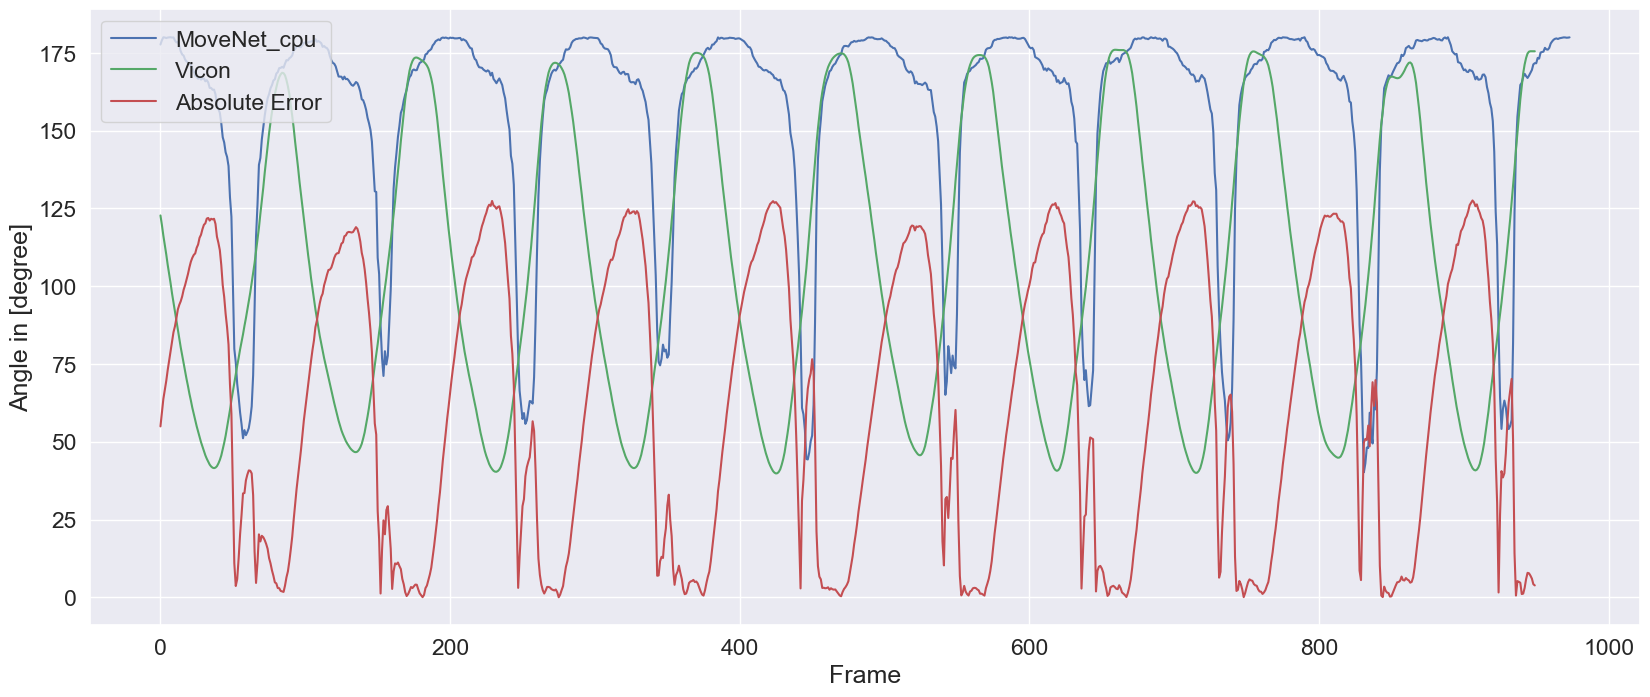

In [15]:
residuum = np.abs(angles_ar - angles_vi)
fig = plt.figure(figsize=(20,8))
sns.set(font_scale = 1.5)
sns.lineplot(data=angles_ar, color='b', label=framework)
sns.lineplot(data=angles_vi, color='g', label='Vicon')
ax = sns.lineplot(data=residuum, color='r', label='Absolute Error')
ax.set(ylabel = "Angle in [degree]", xlabel="Frame")
plt.legend(loc='upper left')

In [16]:
best_shift = align_timeseries(angles_ar, angles_vi)
print(best_shift)
angles_ar_shift, angles_vi_shift = shift_timeseries(angles_ar, angles_vi, best_shift)
angles_ar_shift, angles_vi_shift = cut_timeseries(angles_ar_shift, angles_vi_shift)

21


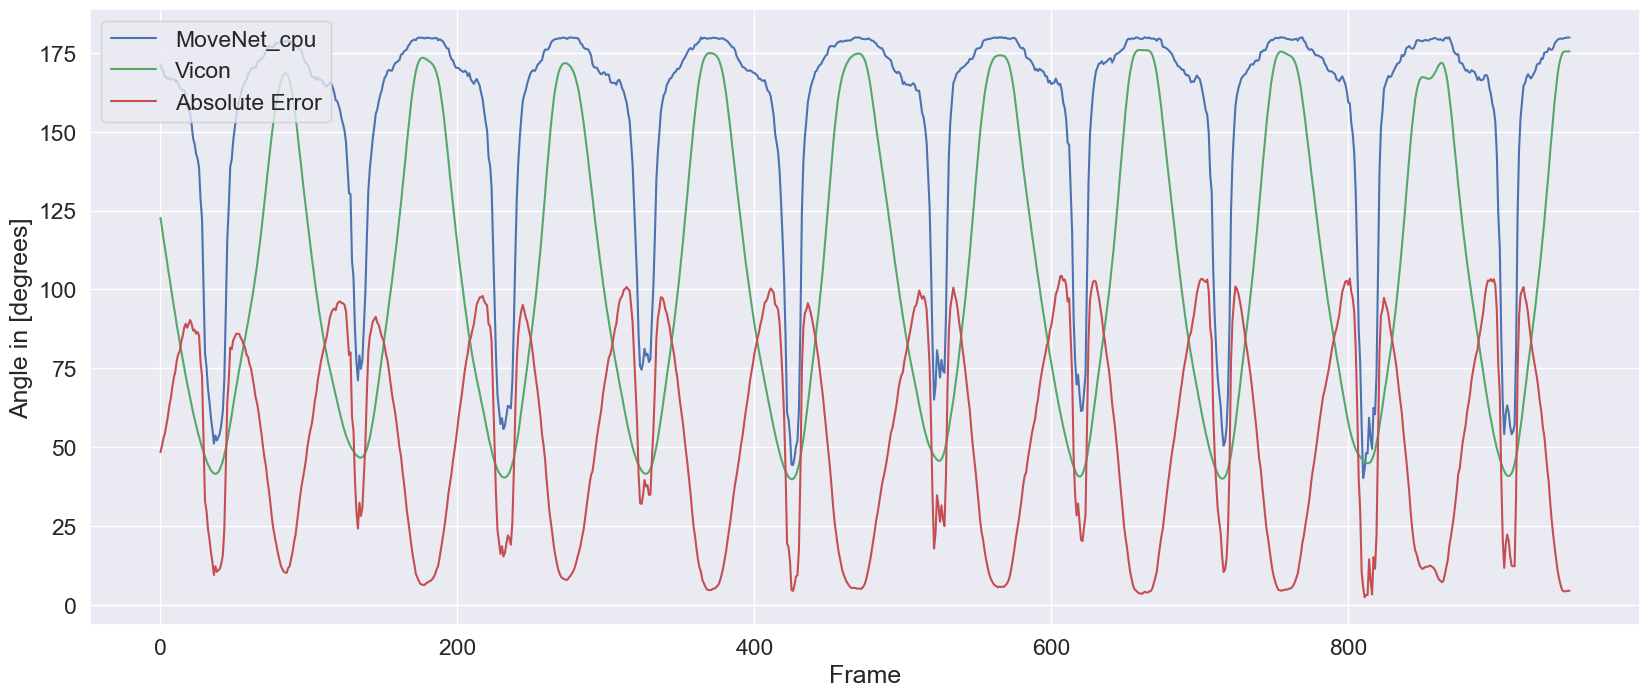

In [17]:
residuum_shift = np.abs(angles_ar_shift - angles_vi_shift)
fig = plt.figure(figsize=(20,8))
sns.set(font_scale = 1.5)
sns.lineplot(data=angles_ar_shift, color='b', label=framework)
sns.lineplot(data=angles_vi_shift, color='g', label='Vicon')
ax = sns.lineplot(data=residuum_shift, color='r', label='Absolute Error')
ax.set(ylabel = "Angle in [degrees]", xlabel="Frame")
plt.legend(loc='upper left')

In [18]:
# Dimension names and sizes
subjects_int = sorted([int(s.rsplit('/', 1)[1]) for s in subjects])
all_combinations = list(product(subjects_int, exercises, views))
df_best_shifts = pd.DataFrame(all_combinations, columns=['Subject', 'Exercise', 'View'])
df_best_shifts['best_shift'] = None
number_shifts = 3

for subject in subjects_int:
    for exercise in exercises:
        for view in views:
            try:
                angles_ar, angles_vi, _ = compute_angles(
                    df,
                    angles_benchmark[view][exercise],
                    mapping,
                    ipad_view=view,
                    subject=subject,
                    exercise=exercise,
                )

                # Too short timeseries are ignored
                if (len(angles_ar[~np.isnan(angles_ar)]) < 100) or (len(angles_vi[~np.isnan(angles_vi)]) < 100):
                    raise

                best_shift = align_timeseries(angles_ar, angles_vi)
                angles_ar_shift, angles_vi_shift = shift_timeseries(angles_ar, angles_vi, best_shift)
                angles_ar_shift, angles_vi_shift = cut_timeseries(angles_ar_shift, angles_vi_shift)

                df_best_shifts.loc[(df_best_shifts['Subject'] == subject) &
                               (df_best_shifts['Exercise'] == exercise) &
                               (df_best_shifts['View'] == view),
                                'best_shift'] = best_shift

                residuum_shift = np.abs(angles_ar_shift - angles_vi_shift)
                fig = plt.figure(figsize=(20,8))
                sns.set(font_scale = 1.5)
                sns.lineplot(data=angles_ar_shift, color='b', label=framework)
                sns.lineplot(data=angles_vi_shift, color='g', label='Vicon')
                ax = sns.lineplot(data=residuum_shift, color='r', label='Absolute Error')
                ax.set(ylabel = "Angle in [degrees]", xlabel="Frame")
                plt.legend(loc='upper left')
                if not os.path.exists(path_control_plots+framework+'/'):
                    # If it doesn't exist, create the folder
                    os.makedirs(path_control_plots+'/'+framework+'/')
                path = path_control_plots+framework+'/'+framework+'_'+('0'+str(subject))[-2:]+'_'+exercise+'_'+view+'_'+angles_benchmark[view][exercise][1]+'.png'
                plt.title(path)
                plt.savefig(path)
                plt.close('all')
            except:
                print('Did not work: ', subject, exercise, view)
df_best_shifts.to_csv(path_best_shifts+'best_shifts_'+framework+'.csv')

Did not work:  1 Front lunge Side
Did not work:  1 Jumping jacks Side
Did not work:  1 Lateral arm raise Side
Did not work:  1 Leg extension crunch Side
Did not work:  1 Reverse fly Side
Did not work:  1 Side squat Side
Did not work:  1 Single leg deadlift Side
Did not work:  1 Squat Side
Did not work:  7 Single leg deadlift Frontal
Did not work:  7 Single leg deadlift Side


In [19]:
# Output PDF file
pdf_filename = path_control_plots+framework+'_control_plots.pdf'

# List all PNG files in the folder
png_files = [file for file in os.listdir(path_control_plots+framework+'/') if file.startswith(framework) and file.endswith('.png')]

png_files.sort()

with PdfPages(pdf_filename) as pdf:
    for png_file in png_files:
        # Open each PNG image using PIL
        img_path = os.path.join(path_control_plots+framework+'/', png_file)
        img = Image.open(img_path)

        # Create a new figure and plot the image
        plt.figure(figsize=(img.width / 100, img.height / 100), dpi=100)
        plt.imshow(img)
        plt.axis('off')

        pdf.savefig(bbox_inches='tight', pad_inches=0)
        plt.close()